In [ ]:
# 

# import modules

In [ ]:

import numpy as np        
import pandas as pd

import csv 
import re
from pathlib import Path

# Bag-of-words / TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

# Evaluation
from sklearn.metrics import precision_recall_fscore_support

# NLP (tokenization, lemmatization, phrase matching)
import spacy
from spacy.matcher import PhraseMatcher
from spacy.lang.en.stop_words import STOP_WORDS
             
import matplotlib.pyplot as plt

import seaborn as sns

: 

# import pdfs

In [ ]:
import  fitz
from pathlib import Path

def textgrabber (Path, mode):
    with fitz.open(Path) as doc:
        return "\n".join(page.get_text(mode) for page in doc)
    
pdf_dir = Path("UCSC_NLP_Project")



docs = []
names = []
for p in sorted(pdf_dir.glob("*.pdf")):
    try:
        docs.append(textgrabber(p, mode="text"))
        names.append(p.name)
    except Exception as e:
        print(f"Failed {p}: {e}")

print(f"Loaded {len(docs)} PDFs")



print 



Loaded 49 PDFs


<function print>

# run lema and vectorizer on pdfs

In [ ]:

nlp = spacy.load("en_core_web_sm", disable=["ner", "parser"])

class SpacyLemma(BaseEstimator, TransformerMixin):
    def __init__(self, keep_pos=("NOUN","PROPN","VERB","ADJ")):
        self.keep_pos = set(keep_pos)
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        # Batch for speed
        out = []
        for doc in nlp.pipe(X, batch_size=100):
            toks = [
                t.lemma_.lower()
                for t in doc
                if t.is_alpha and not t.is_stop and t.pos_ in self.keep_pos
            ]
            out.append(" ".join(toks))
        return out

pipe = Pipeline([
    ("lemma", SpacyLemma()),
    ("tfidf", TfidfVectorizer(
        ngram_range=(1, 2),
        min_df=2,
        max_df=0.9,

        lowercase=False,
        token_pattern=r"(?u)\b[^\W\d_]{2,}\b"
    ))
])


pipe2 = Pipeline([
    ("lemma", SpacyLemma()),
    ("tfidf", CountVectorizer(
        ngram_range=(1, 2),
        min_df=2,
        max_df=0.9,
        lowercase=False,
        token_pattern=r"(?u)\b[^\W\d_]{2,}\b"
    ))
])

X = pipe.fit_transform(docs)
terms = pipe.named_steps["tfidf"].get_feature_names_out()

Y = pipe2.fit_transform(docs)
terms2 = pipe.named_steps["tfidf"].get_feature_names_out()


def top_terms_row(sparse_row, terms, k=100):
    # sparse_row is 1 x n csr
    data = sparse_row.data
    idx = sparse_row.indices
    if data.size == 0:
        return []
    # get top-k indices via argpartition (no full sort)
    k = min(k, data.size)
    topk_local = np.argpartition(-data, k-1)[:k]
    # sort those top-k by score desc
    order = np.argsort(-data[topk_local])
    top_idx = idx[topk_local][order]
    return [terms[j] for j in top_idx]


print("TDIDF score")
for i, name in enumerate(names):
    print(name, "→", top_terms_row(X[i], terms, k=100))

print("counts")

for i, name in enumerate(names):
    print(name, "→", top_terms_row(Y[i], terms2, k=100))



TDIDF score
Copy of A. Priyadarsini et al. 2023.pdf → ['rice field', 'rice', 'methanol', 'methane', 'field', 'mm', 'al', 'et', 'et al', 'field soil', 'soil', 'ph mm', 'methanotroph', 'methanol production', 'production', 'batch mode', 'patel', 'consortium', 'culture', 'mode', 'μm', 'priyadarsini', 'amplification', 'genomic dna', 'enrich', 'pcr', 'capsulatus', 'lane', 'dna', 'ph', 'batch', 'formate mm', 'mm patel', 'reports', 'smmo', 'patel et', 'rhizosphere', 'priyadarsini et', 'mm μm', 'pure strain', 'genomic', 'lee', 'air', 'gene', 'buryatense', 'biogas', 'mmoy', 'natural gas', 'kalia', 'mm formate', 'natural', 'sample', 'flaring', 'detection', 'energy', 'subunit', 'formate', 'soil sample', 'dna extraction', 'methane methanol', 'type', 'μm μm', 'kim', 'india', 'methylococcus capsulatus', 'bacteria', 'strain', 'day', 'methylococcus', 'mm mm', 'bioresource technology', 'technol patel', 'primer', 'methanotrophic', 'bioresource', 'microbiol', 'conversion', 'technol', 'technology', 'paddy'

# turn the data into insights


Top words across all PDFs:
methanol: 7.582542140685413
methane: 6.338809255265375
cell: 4.353124384976775
al: 4.118947122940814
et: 3.7700975345405916
et al: 3.7395198577970192
production: 2.8690972348818886
methanotroph: 2.706278114335029
trichosporium: 2.329015959158255
ml: 2.0031594037612215
rate: 1.961530325023438
reaction: 1.829294425148514
growth: 1.7894072316308824
reactor: 1.7878139286963166
methanol production: 1.738813808733714
mm: 1.7162734735655587
fig: 1.6575861624658035
formate: 1.6081303938053009
ethanol: 1.5358642815662937
time: 1.497734380159043
culture: 1.491154784791693
activity: 1.4611554949165757
phase: 1.432596173695776
figure: 1.416161863264459
biomass: 1.406392065497506
oxidation: 1.3841666187438435
batch: 1.246310173763858
bacteria: 1.2337997317412075
mg: 1.2291856423849408
mmo: 1.19891958168531
conversion: 1.1988219574733503
carbon: 1.1918597516334344
biogas: 1.1910701098583316
methylosinus: 1.189485144602363
methanotrophic: 1.1849288758098653
sample: 1.18032

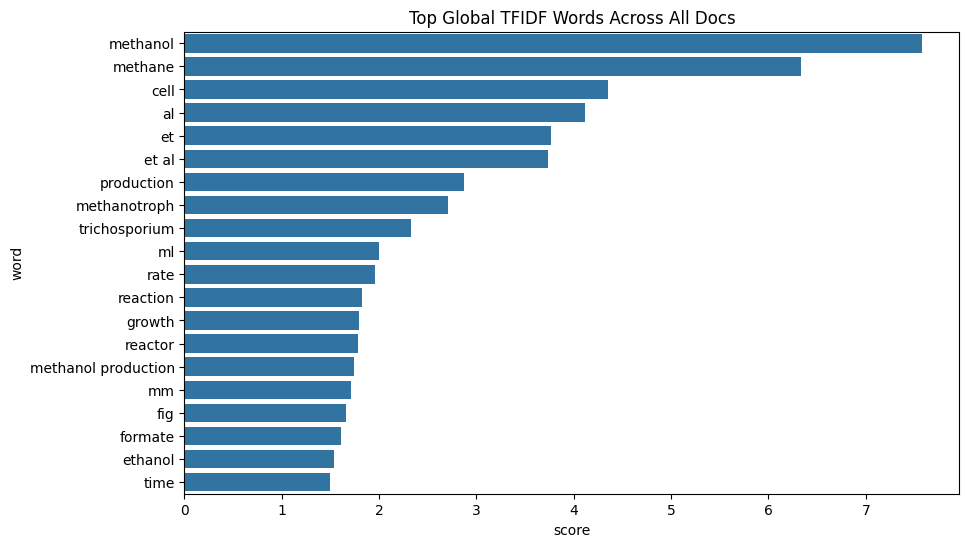

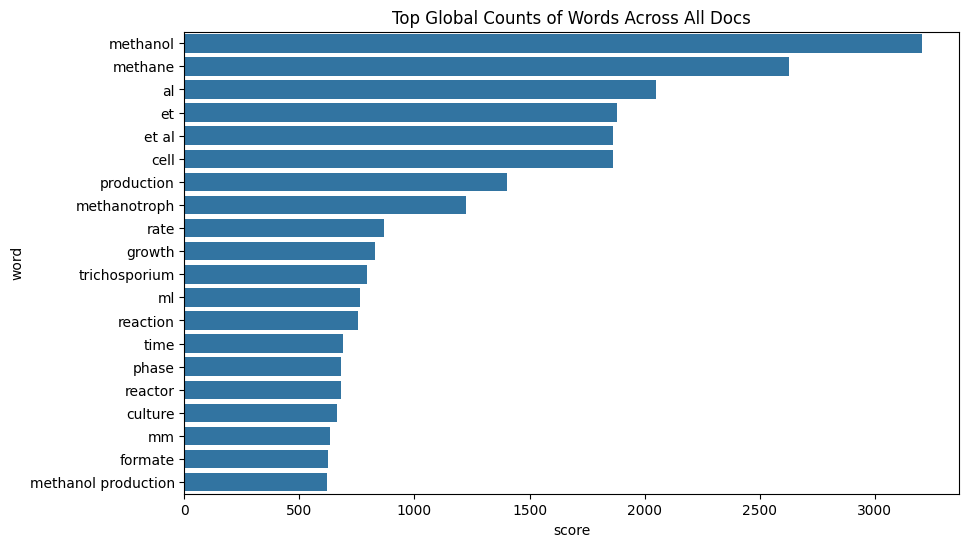

In [ ]:
TDIFchart = pd.DataFrame()
countchart = pd.DataFrame()

doc_results_TDIF = []
doc_results_count = []

# Counts with feature names per document 
for doc_idx, name in enumerate(names):
    TDIF_counts = X[doc_idx].toarray().ravel()
    counts = Y[doc_idx].toarray().ravel()
    word_TDIF_counts = [(terms[i], TDIF_counts[i]) for i in TDIF_counts.nonzero()[0]]
    word_TDIF_counts_sorted = sorted(word_TDIF_counts, key=lambda x: -x[1])
    word_counts = [(terms2[i], counts[i]) for i in counts.nonzero()[0]]
    word_counts_sorted = sorted(word_counts, key=lambda x: -x[1])
    for word, count in word_TDIF_counts_sorted[:40]:
        doc_results_TDIF.append({"doc": name, "word": word, "score": count})
    for word, count in word_counts_sorted[:40]:
        doc_results_count.append({"doc": name, "word": word, "score": count})

df_doc1 = pd.DataFrame(doc_results_count)
df_doc1.to_csv("top_count_words_per_doc.csv", index=False)


df_doc2= pd.DataFrame(doc_results_TDIF)
df_doc2.to_csv("top_TDIDF_words_per_doc.csv", index=False)
# Global counts across all docs 
global_TDIF_counts = np.asarray(X.sum(axis=0)).ravel()
global_TDIF_word_counts = sorted(zip(terms, global_TDIF_counts), key=lambda x: -x[1])
print("\nTop words across all PDFs:")
for word, count in global_TDIF_word_counts[:40]:
    print(f"{word}: {count}")


global_counts = np.asarray(Y.sum(axis=0)).ravel()
global_word_counts = sorted(zip(terms2, global_counts), key=lambda x: -x[1])
print("\nTop words across all PDFs:")
for word, count in global_word_counts[:40]:
    print(f"{word}: {count}")


global_TDIF_counts = np.asarray(X.sum(axis=0)).ravel()
global_word_TDIF = sorted(zip(terms, global_TDIF_counts), key=lambda x: -x[1])[:20]
df_global_tfidf = pd.DataFrame(global_word_TDIF, columns=["word", "score"])

plt.figure(figsize=(10,6))
sns.barplot(y="word", x="score", data=df_global_tfidf)
plt.title("Top Global TFIDF Words Across All Docs")
plt.savefig("TDIDF.png")
plt.show()


global_counts = np.asarray(Y.sum(axis=0)).ravel()
global_word_counts = sorted(zip(terms2, global_counts), key=lambda x: -x[1])[:20]
df_global_counts= pd.DataFrame(global_word_counts, columns=["word", "score"])

plt.figure(figsize=(10,6))
sns.barplot(y="word", x="score", data=df_global_counts)
plt.title("Top Global Counts of Words Across All Docs")
plt.savefig("Counts.png")
plt.show()





    